# 数据预处理

In [27]:
# import
import torch
import torchvision 
from tqdm import tqdm
import matplotlib.pyplot as plt  

In [2]:
# 对于Pytorch，需要手动去定义它是在CPU还是在GPU中训练
# 如果能在GPU中训练，就使用GPU；否则使用CPU进行训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
# Compose : 将多个图像变换操作按顺序组合成一个管道（Pipeline,一系列有序的数据处理步骤。）。 (先 ToTensor，再 Normalize)
# ToTensor ： 把值缩放到 [0, 1.0], 维度固定为3维
# Normalize ： 标准化，mean:均值, std:标准化。 输入:[0, 1.0] -> 输出:[-1.0, 1.0]

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])

In [4]:
path = './data/'  # 数据集下载后保存的目录

# 下载和加载训练集和测试集

trainData = torchvision.datasets.MNIST( # 训练集数据
    path,  # 数据集路径
    train = True,  # 是否加载训练集
    transform = transform,  # 预处理管道
    download = True # 如果数据不存在，是否自动下载数据 (测试集和训练集都下载). 如果没有数据，必须要手动指定为Ture,否则会报错
)

testData = torchvision.datasets.MNIST( # 测试集数据
    path, 
    train = False, 
    transform = transform
)


100%|███████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [01:38<00:00, 101kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 51.5kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:30<00:00, 54.2kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<?, ?B/s]


In [5]:
# 设定每一个Batch的大小（一次性输入模型进行训练或推理的一组样本）
# Batch的作用：
# 1. 防止一次性加载全部数据可能超出内存/显存容量。
# 2. 批量计算可利用并行化加速（如GPU的矩阵运算）。
# 3.小批量数据的梯度比单样本更稳定，比全数据集更高效。
BATCH_SIZE = 256  

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(
    dataset = trainData,
    batch_size = BATCH_SIZE,
    shuffle = True # 每个训练周期（epoch）开始时，随机打乱数据顺序，防止模型记忆样本顺序（避免过拟合）
)

testDataLoader = torch.utils.data.DataLoader(
    dataset = testData,
    batch_size = BATCH_SIZE,
    # 测试集不需要shuffle:测试集的目的是评估模型性能，需要保证每次评估时数据顺序一致，结果可复现。
    # 打乱顺序不会影响评估准确性，但也没有必要。
    shuffle = False 
)


# 训练

## 构建模型

In [10]:
class Net(torch.nn.Module): # torch.nn.Module：PyTorch中所有神经网络模块的基类。
    def __init__(self):
        super(Net,self).__init__()
        # Sequential: 按顺序组合多个神经网络层或模块
        # 输入数据会依次通过 Sequential 中的每一个子模块（层），前一层的输出作为下一层的输入
        self.model = torch.nn.Sequential( 
            
            # 输入图片尺寸：1*28*28(MINIST图片尺寸)
            
            # 第一卷积层
            # Conv2d: 卷积层（Convolutional Layer）
            
            # 参数：
                # 输入通道数（in_channels）：输入数据的通道数（如RGB图像为3，灰度图为1）。
                # 输出通道数（out_channels）：卷积核的数量，决定提取多少种特征。
                # 卷积核大小（kernel_size）：如3x3、5x5。
                # 步长（stride）：卷积核每次滑动的距离。
                # 填充（padding）：在输入边缘补零，控制输出尺寸。
            
            torch.nn.Conv2d(
                in_channels = 1, 
                out_channels = 16,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),

            # 图片尺寸变为16*28*28
            
            # 第一激活层（Activation Layer）
            # 功能：
                # 1. 引入非线性：使网络能够学习复杂模式。
                # 2. 决定神经元是否激活：通过阈值控制信号传递。
            # 激活函数：ReLU（Rectified Linear Unit）
            torch.nn.ReLU(),

            # 第一池化层（Pooling Layer）
            # 作用：
                # 1. 降维：减少特征图尺寸，降低计算量。
                # 2. 平移不变性：对微小位移不敏感。
                # 3. 防止过拟合：减少参数量的间接效果。
            # 最大池化（Max Pooling）：取窗口内最大值。更关注局部显著特征。
            # 参数： 2x2窗口，步长2（尺寸减半）
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2), 

            # 图片尺寸变为16*14*14
#----------------------------------------------------------------------------------------------------------           
            # 第二卷积层
            torch.nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3,stride = 1,padding = 1),

            # 图片尺寸变为32*14*14
            
            # 第二激活层
            torch.nn.ReLU(),
            
            # 第二池化层
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),

            # 图片尺寸变为32*7*7

#----------------------------------------------------------------------------------------------------------
            
            # 第三卷积层
            torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3,stride = 1,padding = 1),

            # 图片尺寸变为64*7*7
            
            # 第三激活层
            torch.nn.ReLU(),

#----------------------------------------------------------------------------------------------------------
            # 全连接

            # 将多维输入张量展平为一维向量。输出尺寸： 64×7×7 = 3136
            torch.nn.Flatten(),

            # 特征压缩和抽象，保留关键信息用于分类
            # 将 3136 维输入映射到 128 维隐藏特征。
            torch.nn.Linear(in_features = 7 * 7 * 64,out_features = 128),

            # 对上一层的输出进行非线性激活。
            torch.nn.ReLU(),

            # 将 128 维特征映射到 10 维输出（对应 MNIST 的 10 个类别）
            torch.nn.Linear(in_features = 128,out_features = 10),
            
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self,input): # forward 方法：定义前向传播过程。
        output = self.model(input)
        return output


In [12]:
net = Net()
#将模型转换到device中，并将其结构显示出来
print(net.to(device))   # to() 方法用于将张量放入到指定的设备（如CPU或GPU中）

Net(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)


## 构建迭代器与损失函数

In [13]:
# 对于简单的多分类任务，我们可以使用交叉熵损失来作为损失函数；
# 而对于迭代器而言，我们可以使用Adam迭代器
lossF = torch.nn.CrossEntropyLoss() # 交叉熵损失函数，用于计算模型输出与真实标签之间的误差。
optimizer = torch.optim.Adam(net.parameters()) # 用于更新模型参数以最小化损失

## 构建训练循环

In [14]:
# ⋯→训练→验证→下一轮训练→下一轮验证→…

In [32]:
EPOCHS = 10 #总的循环
#存储训练过程
history = {'Test Loss':[],'Test Accuracy':[]}

for epoch in range(1,EPOCHS + 1):
    """
    训练部分
    """
    
    # 构建tqdm进度条，方便观察
    processBar = tqdm(trainDataLoader,unit = 'step')
    
    # 打开网络的训练模式
    net.train(True)
    
    # 开始对训练集的DataLoader进行迭代
    # enumerate 遍历会返回index和value, 此处step就是index
    # (trainImgs,labels)是DataLoader中的一个数据-标签对
    for step,(trainImgs,labels) in enumerate(processBar): 
    	
    	# 将图像和标签传输进device中
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)
    	
    	# 清空模型的梯度,防止积累梯度。如果不手动清零梯度，梯度会在多个批次中不断累积，导致错误的参数更新。
        net.zero_grad()
        
        # 对模型进行前向推理
        # 将图像输入网络，得到原始输出logits（未归一化的预测值）
        outputs = net(trainImgs)
        
        # 计算本轮推理的Loss值
        # outputs: 模型预测的原始分数
        # labels: 真实类别标签
        loss = lossF(outputs,labels)
        
        # 计算本轮推理的准确率
        predictions = torch.argmax(outputs, dim = 1)
        
        # 统计预测正确的样本数，除以总样本数得到准确率
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        
        # 进行反向传播求出模型参数的梯度
        loss.backward()
    
    	# 使用优化器根据梯度调整参数
        optimizer.step()
    
    	# 将本step结果进行可视化处理
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                       (epoch,EPOCHS,loss.item(),accuracy.item()))

        """
    	测试部分
    	"""

        #构造临时变量
        correct,totalLoss = 0,0
        
        #关闭模型的训练状态
        net.train(False)
        
        #对测试集的DataLoader进行迭代
        for testImgs,labels in testDataLoader:
            testImgs = testImgs.to(device)
            labels = labels.to(device)
            outputs = net(testImgs)
            loss = lossF(outputs,labels)
            predictions = torch.argmax(outputs,dim = 1)
                        
            #存储测试结果
            totalLoss += loss
            correct += torch.sum(predictions == labels)
        
        #计算总测试的平均准确率
        testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))
        
        #计算总测试的平均Loss
        testLoss = totalLoss/len(testDataLoader)
        
        history['Test Loss'].append(testLoss.item()) # 记录loss
        history['Test Accuracy'].append(testAccuracy.item()) # 记录acc
        
        #将本step结果进行可视化处理
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %             
                        (epoch,EPOCHS,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))


[1/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4705, Test Acc: 0.9675: 100%|████████████| 235/235 [07:18<00:00,  1.86s/step]
[2/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4698, Test Acc: 0.9679: 100%|████████████| 235/235 [07:15<00:00,  1.86s/step]
[3/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4693, Test Acc: 0.9688: 100%|████████████| 235/235 [07:17<00:00,  1.86s/step]
[4/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4716, Test Acc: 0.9663: 100%|████████████| 235/235 [07:15<00:00,  1.85s/step]
[5/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4702, Test Acc: 0.9672: 100%|████████████| 235/235 [07:16<00:00,  1.86s/step]
[6/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4700, Test Acc: 0.9678: 100%|████████████| 235/235 [07:16<00:00,  1.86s/step]
[7/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4703, Test Acc: 0.9673: 100%|████████████| 235/235 [07:15<00:00,  1.85s/step]
[8/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4700, Test Acc: 0.9676: 100%|████████████| 235/235 [07:19<00:00,  1.87s/step]


# 数据预后处理部分

## 训练结果可视化

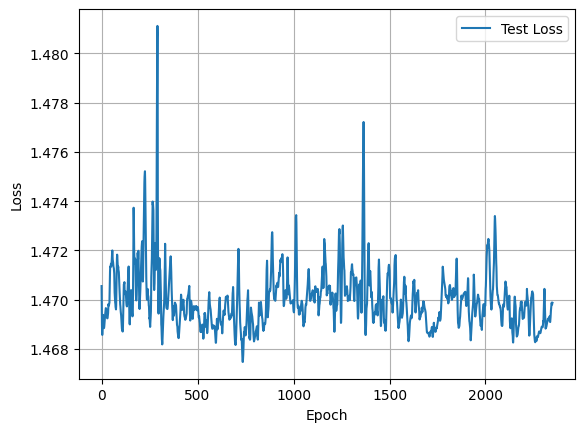

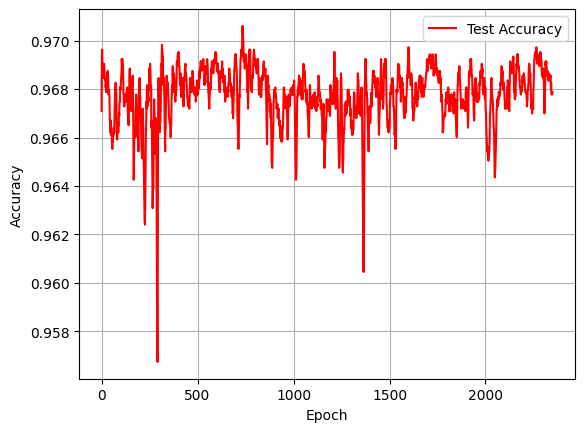

In [33]:
#对测试Loss进行可视化
plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#对测试准确率进行可视化
plt.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


## 保存模型

In [34]:
torch.save(net,'./model.pth')

NameError: name 'history' is not defined